## Load Dataset

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from random import randint
import numpy as np
import pandas as pd
import time
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import utils

classes = {"Black-naped Oriole": 0,
          "Brown-throated Sunbird": 1,
          "Collared Kingfisher": 2, 
          "Javan Myna": 3, 
          "Olive-backed Sunbird": 4, 
          "Pink-necked Green Pigeon": 5, 
          "Spotted Dove": 6, 
          "Striated Heron": 7, 
          "White-breasted Waterhen": 8, 
          "Yellow-vented Bulbul": 9,
          "Background": 0}

label_folder_name = 'labels/bboxes_after_split/'
dataset_folder_name = 'images/'

In [2]:
def load_data_and_label(csv):
    convert_tensor = torchvision.transforms.ToTensor()

    all_data = None
    all_labels = []

    df = pd.read_csv(label_folder_name + csv)
    image_names = df["image_name"].unique()   
    
    df = df.drop(columns = ['image_width', 'image_height'])
    df['label'] = df['label'].apply(lambda class_name : classes[class_name])
    
    # Load images and corresponding bbox labels
    for image_name in image_names:
        # Remove transparency layer
        img = Image.open(dataset_folder_name + image_name).convert('RGBA')
        background = Image.new('RGBA', img.size, (255,255,255))
        alpha_composite = Image.alpha_composite(background, img)
        img = alpha_composite.convert('RGB')
        
        data = convert_tensor(img)        
        data = torch.unsqueeze(data, 0)

        if all_data == None:
            all_data = data
        else:
            all_data = torch.cat((all_data, data), 0)
            
        # Get corresponding labels
        labels = df.loc[df['image_name'] == image_name]
        labels = labels.drop(columns = ['image_name'])
        labels = torch.LongTensor(labels.to_numpy())
        
        all_labels.append(labels)

    return all_data, all_labels
    

In [54]:
device= torch.device("cpu")

In [4]:
train_images, train_label = load_data_and_label('train_bbs.csv')
print(train_images.size())
print(len(train_label))

val_images, val_label = load_data_and_label('val_bbs.csv')
print(val_images.size())
print(type(val_images))
print(len(val_label))
print(type(val_label))

torch.Size([700, 3, 224, 224])
700
torch.Size([150, 3, 224, 224])
<class 'torch.Tensor'>
150
<class 'list'>


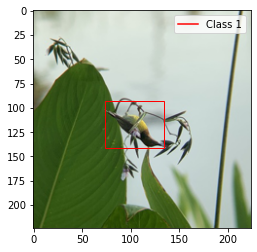

In [17]:
# Print out a test image

# Takes in the image as (3, 224, 224) tensor, label as a tensor of size (k, 5) where k is # of bboxes. Information is
# in the following order (label, top_left_x, top_left_y, width, height) and displays it
def display_bbox_and_image(image, bboxes):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    plt.imshow(image.permute(1, 2, 0)) # matplotlib needs it as (224, 224, 3)
    
    for box_num in range(bboxes.shape[0]):
        label, x, y, width, height = bboxes[box_num]
        color = 'r'
        
        rect = matplotlib.patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
    plt.plot(x,y,color,label=f"Class {label.item()}") # To show something in the legend
        
    plt.legend(loc='best')
    plt.show() 
    
display_bbox_and_image(train_images[100], train_label[100])

## Define Model

Total Number of Region Proposals: 256


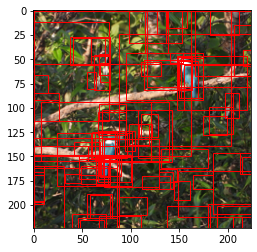

In [59]:
# Selective Search algorithm

def get_selective_search_bboxes(image):
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()

    # run selective search segmentation on input image
    rects = ss.process()
    print('Total Number of Region Proposals: {}'.format(len(rects)))
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    plt.imshow(image)
    
    for box_num in range(rects.shape[0]):
        if box_num > 100: break
        x, y, width, height = rects[box_num]
        color = 'r'
        
        rect = matplotlib.patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
                
    plt.show() 
    
get_selective_search_bboxes(np.array(train_images[234].permute(1, 2, 0)))


In [41]:
# Precalculate region proposals for all training and validation images

# Take first 50 selecive search predictions for speed's sake, proposals are ordered by quality anyways

In [60]:
class fast_R_CNN(nn.Module):
    
    def __init__(self):
        super(fast_R_CNN, self).__init__()
        
        NUM_CLASSES = 11
        # backbone convnet
        # block 1:         3 x 224 x 224 --> 32 x 224 x 224        
        self.conv1a = nn.Conv2d(3,   32,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         32 x 112 x 112 --> 64 x 112 x 112
        self.conv2a = nn.Conv2d(32,  64, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # roi_pooling
        self.roi_pool = torchvision.ops.RoIPool(output_size = (28, 28), spatial_scale = 0.5)
                
        # Per region convnet
        # block 1: 64 x 28 x 28 -> 128 x 14 x14
        self.rconv1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.rpool1 = nn.MaxPool2d(2,2)
        
        # block 2: 128 x 14 x 14 -> 256 x 1
        self.rconv2 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.rpool2 = nn.MaxPool2d(14, 14)
            
        # Bbox classes
        self.linear_class = nn.Linear(256, NUM_CLASSES)
        # Bbox anchors
        self.linear_bbox_transforms = nn.Linear(256, 4) 
        
    # bb_candidates is a tensor of shape (k, 5), where 2nd dim contains (index, x1, y1, x2, y2) and we have k prospective bounding boxes
    def forward(self, x, bb_candidates):
        # backbone convnet
        x = self.conv1a(x) # [batch_size, hidden_dim, im_size, im_size] 
        x = torch.relu(x)
        x = self.conv1b(x)
        x = self.pool1(x)
        x = torch.relu(x)
        
        x = self.conv2a(x) # [batch_size,hidden_dim, im_size, im_size]
        x = torch.relu(x) 
        x = self.conv2b(x)
        x = torch.relu(x)
        
        # ROI Pooling
        x = self.roi_pool(x, bb_candidates) # [K, channels, 28, 28]
        
        # Per-region network
        x = self.rconv1(x)
        x = self.rpool1(x)
        x = torch.relu(x)
        
        x = self.rconv2(x)
        x = self.rpool2(X)
        x = torch.relu(x) # [K, 512, 1, 1]
        
        # Get bbox classes and anchors
        x = x.view(-1, 512)
        bbox_class = self.linear_class(x) # [K, 11]
        bbox_transforms = self.linear_bbox_transforms(x) # [K, 4]
        
        return bbox_class, bbox_transforms


In [61]:
net=fast_R_CNN()

print(net)
utils.display_num_param(net)

fast_R_CNN(
  (conv1a): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (roi_pool): RoIPool(output_size=(28, 28), spatial_scale=0.5)
  (rconv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rconv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rpool2): MaxPool2d(kernel_size=14, stride=14, padding=0, dilation=1, ceil_mode=False)
  (linear_class): Linear(in_features=256, out_features=11, bias=True)
  (linear_bbox_transforms): Linear(in_features=256, out_features=4, bias=True)
)
There are 1323439 (1.32 million) parameter

In [62]:
mean= train_images.mean()
std = train_images.std()
print(mean, std)

tensor(0.4702) tensor(0.2632)


In [63]:
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
bs = 32

In [ ]:
start=time.time()

for epoch in range(1,20):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        inputs = (minibatch_data - mean)/std
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')
    
           